In [64]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

import pandas as pd
from scipy import stats

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%config IPCompleter.use_jedi = False

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

SVMs: discriminative classification
> rather than modeling each class, we simply find a line or curve (in two dimensions) or manifold (in multiple dimensions) that divides the classes from each other.

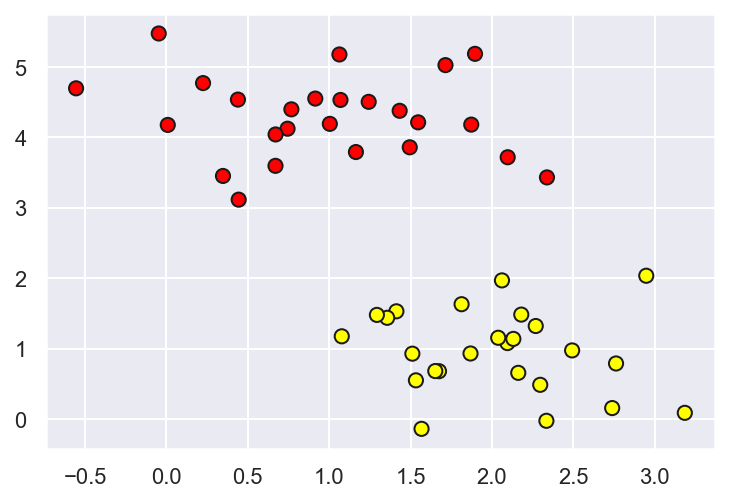

In [66]:
from sklearn.datasets.samples_generator import make_blobs
X, y = make_blobs(n_samples=50, centers=2,
                  random_state=0, cluster_std=0.60)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn', edgecolors='k');

SVM aims to draw a dividing line, however, there is no unique solution

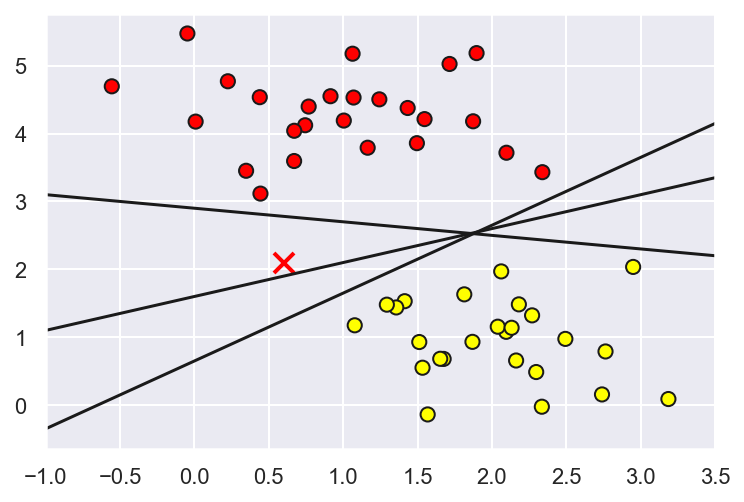

In [69]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn', edgecolors='k')
plt.plot([0.6], [2.1], 'x', color='red', markeredgewidth=2, markersize=10)

for m, b in [(1, 0.65), (0.5, 1.6), (-0.2, 2.9)]:
    plt.plot(xfit, m * xfit + b, '-k')

plt.xlim(-1, 3.5);

SVM aims to maximize the margin: a unique solution

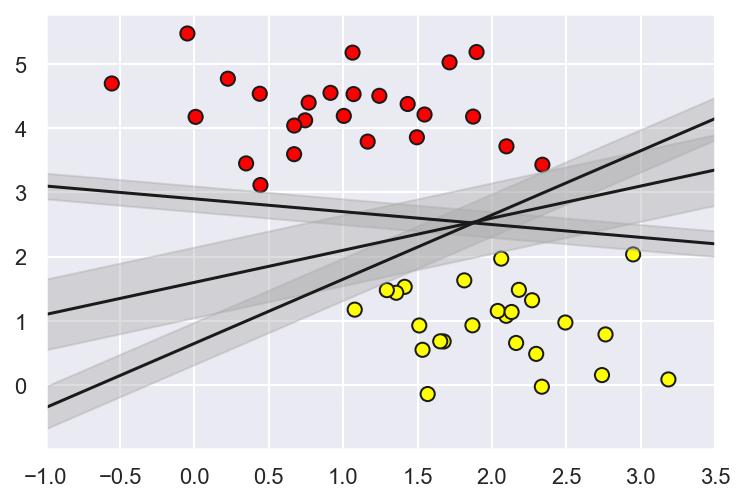

In [71]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn', edgecolors='k')

for m, b, d in [(1, 0.65, 0.33), (0.5, 1.6, 0.55), (-0.2, 2.9, 0.2)]:
    yfit = m * xfit + b
    plt.plot(xfit, yfit, '-k')
    plt.fill_between(xfit, yfit - d, yfit + d, edgecolor='none',
                     color='#AAAAAA', alpha=0.4)

plt.xlim(-1, 3.5);

### Fitting a SVC

In [72]:
from sklearn.svm import SVC # "Support vector classifier"
model = SVC(kernel='linear', C=1E10)
model.fit(X, y)

SVC(C=10000000000.0, kernel='linear')

In [86]:

def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, facecolors='None', edgecolors='k');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

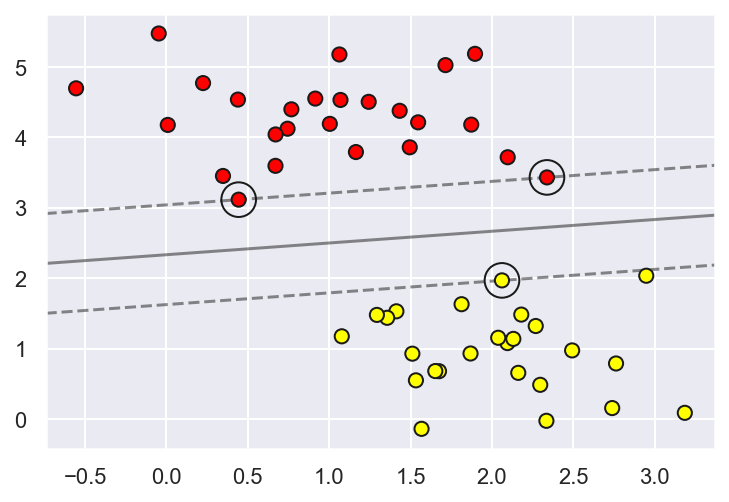

In [87]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn', edgecolors='k',zorder=5)
plot_svc_decision_function(model);

In [88]:
model.support_vectors_

array([[0.44359863, 3.11530945],
       [2.33812285, 3.43116792],
       [2.06156753, 1.96918596]])

NB: Only the support vectors matter to the fit; adding data points that are outside of the margin will not change the fit.

### Kernel SVM: non-linear boundaries


An example of a classification problem that cannot be solved by a linear kernel

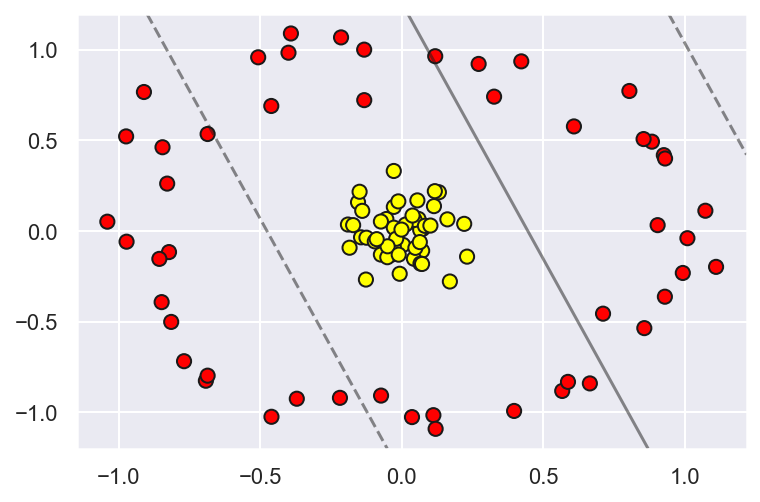

In [95]:
from sklearn.datasets.samples_generator import make_circles
X, y = make_circles(100, factor=.1, noise=.1)

clf = SVC(kernel='linear').fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn', edgecolors='k')
plot_svc_decision_function(clf, plot_support=False);

In [96]:
clf = SVC(kernel='rbf', C=1E6)
clf.fit(X, y)

SVC(C=1000000.0)

The `sklearn` RBF has the following form

$ \Large
\begin{equation}
    k(x_i,x_j) = \exp\bigg(- \frac{d(x_i,x_j)^2}{2l^2} \bigg)  
\end{equation}
$

which is known as the kernel trick: for some kernel $\phi(x)$ the \emph{kernel function} describes the dotproduct between two kernel vectors

$ \Large
\begin{equation}
    k(x,z) = \bigg\langle \phi(x), \phi(z) \bigg\rangle
\end{equation}
$

SVMs make use of the fact that the exact form of the kernel does not have to be specified (i.e. in the case of the RBS the origin is unknown). However, by SVMs *linearly* separate the classes in the transformed kernel space using the kernel function.

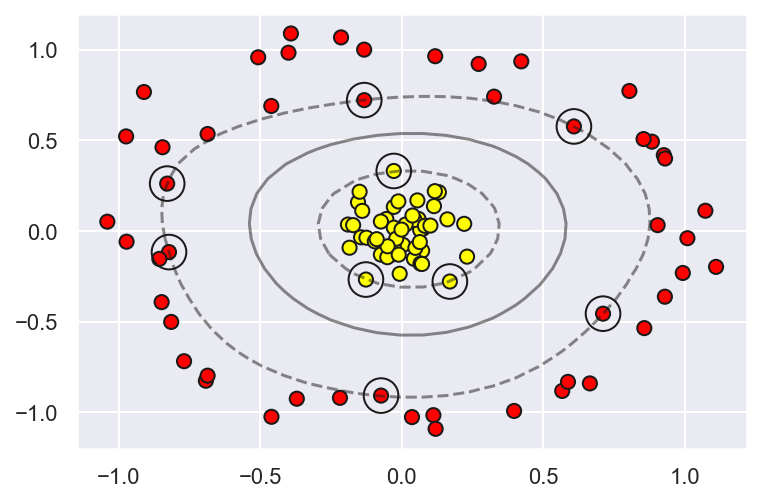

In [97]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn', edgecolors='k')
plot_svc_decision_function(clf)
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
            s=300, lw=1, facecolors='none');

### What if data is non-separable?

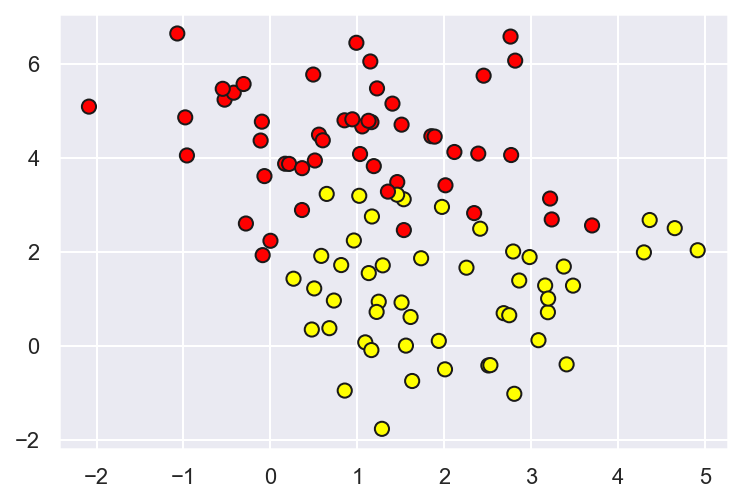

In [107]:
X, y = make_blobs(n_samples=100, centers=2,
                  random_state=0, cluster_std=1.2)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn', edgecolors='k');

This is where the SVM fudge factor `C` comes in: it allows points to be within the margin if that improves the fit

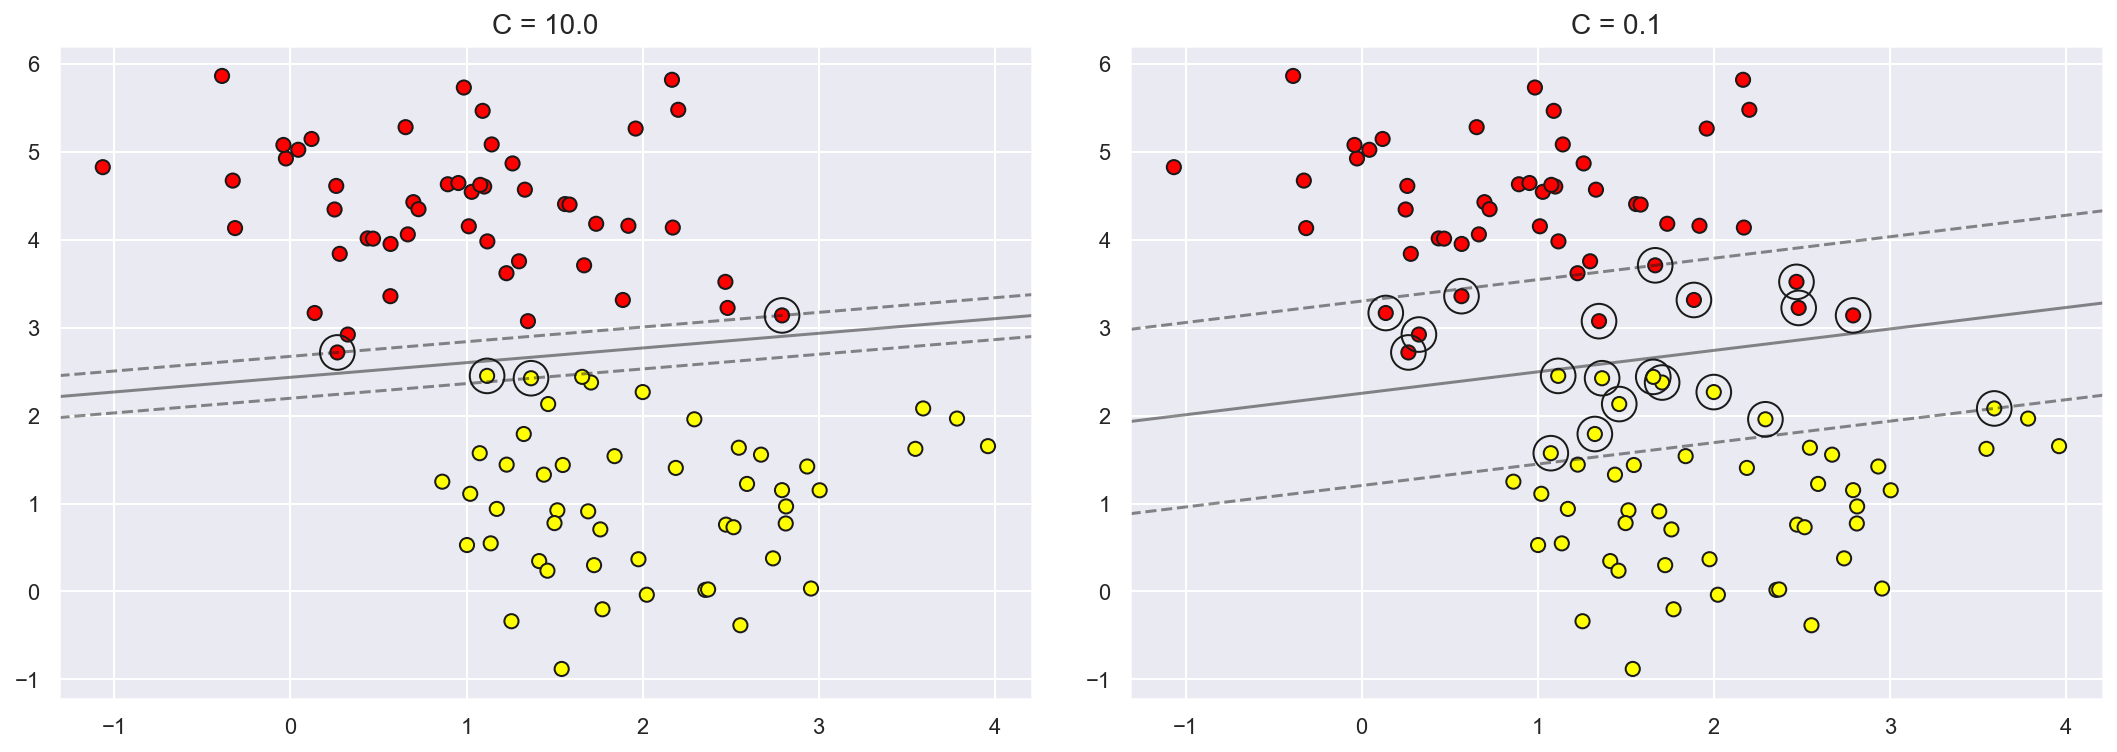

In [110]:
X, y = make_blobs(n_samples=100, centers=2,
                  random_state=0, cluster_std=0.8)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

for axi, C in zip(ax, [10.0, 0.1]):
    model = SVC(kernel='linear', C=C).fit(X, y)
    axi.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn', edgecolors='k')
    plot_svc_decision_function(model, axi)
    axi.scatter(model.support_vectors_[:, 0],
                model.support_vectors_[:, 1],
                s=300, lw=1, facecolors='none');
    axi.set_title('C = {0:.1f}'.format(C), size=14)